<a href="https://colab.research.google.com/github/serafinazhang/Urban-Sound-Classification/blob/main/Urban_Sound_Classification_Code_Book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Urban Sound Classification with Neural Networks**

# 1 Data Preprcessing

## 1.1 Preparation

In [4]:
!pip install librosa
import librosa
import librosa.display
# !pip install specAugment

In [2]:
import pandas as pd
import numpy as np
import glob
import os
import tarfile
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from google.colab import files
from zipfile import ZipFile

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from PIL import Image
import pathlib
import csv
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix, accuracy_score, zero_one_loss
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, Input, Add, TimeDistributed, LSTM, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization, Lambda, GRU, concatenate
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras import backend
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.optimizers import adam_v2

In [ ]:
file = tarfile.open("/content/drive/MyDrive/machine learning/UrbanSound8K.tar.gz")
file.extractall('/content/')

In [ ]:
path = '/content/UrbanSound8K/audio/'
def pre_clean(fold):
  path_list = []
  labels = []
  folds = []
  for i in fold:
    this_path = os.path.join(path,i)
    for root, dirs, files_name in os.walk(this_path):
      files_name.remove('.DS_Store')
      for file in files_name:
        path_list.append(os.path.join(root,file))
        label = file.split('-')[1]
        folds.append(i)
        labels.append(label)
  return path_list, labels, folds

In [ ]:
train_path_list, train_labels, train_folds = pre_clean(train_fold)
test_path_list, test_labels, test_folds = pre_clean(test_fold)

In [ ]:
# get raw data from load function
def loading_raw(path_list):
  raw_list = []
  for i in path_list:
    raw, st = librosa.load(i)
    raw_list.append(raw)
  return raw_list

In [ ]:
train_raw = loading_raw(train_path_list)
test_raw = loading_raw(test_path_list)

In [ ]:
np.array(train_raw,dtype=object).dump(open('/content/drive/MyDrive/machine learning/raw data/train_raw.npy', 'wb'))
np.array(test_raw,dtype=object).dump(open('/content/drive/MyDrive/machine learning/raw data/test_raw.npy', 'wb'))

In [ ]:
train_label = pd.DataFrame({'fold': train_folds, 'label': train_labels, 'path_list': train_path_list})
test_label = pd.DataFrame({'fold': test_folds, 'label': test_labels, 'path_list': test_path_list})

In [ ]:
train_label.to_csv('/content/drive/MyDrive/machine learning/raw data/train_label.csv')
test_label.to_csv('/content/drive/MyDrive/machine learning/raw data/test_label.csv')

## 1.2 Data Loading

###1.2.1 Loading Raw

In [ ]:
train_fold = ['fold1', 'fold2', 'fold3', 'fold4', 'fold6']
test_fold = ['fold5', 'fold7', 'fold8', 'fold9', 'fold10']

In [ ]:
train_raw = np.load('/content/drive/MyDrive/machine learning/raw data/train_raw.npy', allow_pickle=True) # sample rate is 22050Hz
test_raw = np.load('/content/drive/MyDrive/machine learning/raw data/test_raw.npy', allow_pickle=True)

In [ ]:
train_meta = pd.read_csv('/content/drive/MyDrive/machine learning/raw data/train_label.csv')
test_meta = pd.read_csv('/content/drive/MyDrive/machine learning/raw data/test_label.csv')

In [ ]:
def extract_name(x):
  l = x.split('/')
  name = l[-1]
  name = name.split('.')[0]
  return name

In [ ]:
train_meta['name'] = train_meta['path_list'].apply(extract_name)
test_meta['name'] = test_meta['path_list'].apply(extract_name)

In [ ]:
valid_raw = test_raw[:936]
test_raw = test_raw[936:]

In [ ]:
valid_meta = test_meta[:936]

In [ ]:
test_meta = test_meta[936:].reset_index()

###1.2.2 Slicing

In [ ]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)

In [ ]:
def re_split(raw_data, meta_data, frames = 41):
  column_names = ['name', 'fold', "label"]
  df = pd.DataFrame(columns=column_names)
  array_list = []

  window_size = 512 * (frames - 1)
  for i in range(len(raw_data)):
    sound_clip = raw_data[i]

    for (start,end) in windows(sound_clip,window_size):
      if(len(sound_clip[int(start):int(end)]) == int(window_size)):
        signal = sound_clip[int(start):int(end)]
        array_list.append(signal)
        df = df.append({'name': meta_data['name'][i], 'fold': meta_data['fold'][i], 'label': meta_data['label'][i]}, ignore_index = True)

  return np.array(array_list), df

In [ ]:
train_raw_split, train_meta_split = re_split(train_raw, train_meta)
test_raw_split, test_meta_split = re_split(test_raw, test_meta)
valid_raw_split, valid_meta_split = re_split(valid_raw, valid_meta)

In [ ]:
np.save('/content/drive/MyDrive/machine learning/train_raw_split.npy', train_raw_split)
np.save('/content/drive/MyDrive/machine learning/test_raw_split.npy', test_raw_split)
np.save('/content/drive/MyDrive/machine learning/valid_raw_split.npy', valid_raw_split)

In [ ]:
train_meta_split.to_csv('/content/drive/MyDrive/machine learning/train_meta_split.csv')
test_meta_split.to_csv('/content/drive/MyDrive/machine learning/test_meta_split.csv')
valid_meta_split.to_csv('/content/drive/MyDrive/machine learning/valid_meta_split.csv')

In [ ]:
train_raw_split = np.load('/content/drive/MyDrive/machine learning/train_raw_split.npy')
test_raw_split = np.load('/content/drive/MyDrive/machine learning/test_raw_split.npy')
valid_raw_split = np.load('/content/drive/MyDrive/machine learning/valid_raw_split.npy')

In [6]:
train_meta_split = pd.read_csv('/content/drive/MyDrive/machine learning/train_meta_split.csv')
test_meta_split = pd.read_csv('/content/drive/MyDrive/machine learning/test_meta_split.csv')
valid_meta_split = pd.read_csv('/content/drive/MyDrive/machine learning/valid_meta_split.csv')

## 1.3 Data Visualization

## 1.4 Feature Extraction

In [ ]:
def mel_data(raw_data):
  mel_fre = []
  for i in range(len(raw_data)):
    signal = raw_data[i]
    S = librosa.feature.melspectrogram(signal, n_mels = 128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max).T
    f = S_dB.flatten()
    mel_fre.append(f)
  mel_fre = np.asarray(mel_fre).reshape(len(raw_data),41,128)
  return mel_fre

In [ ]:
def mfcc_data(raw_data):
  mfcc = []
  for i in range(len(raw_data)): 
    signal = raw_data[i] 
    S = librosa.feature.mfcc(y=signal, n_mfcc=50)
    S_dB = librosa.power_to_db(S, ref=np.max).T
    f = S_dB.flatten()
    mfcc.append(f)
  mfcc = np.asarray(mfcc).reshape(len(raw_data),41,50) 
  return mfcc

In [ ]:
def chroma_data(raw_data):
  chroma_d = []
  for i in range(len(raw_data)):
    signal = raw_data[i]
    chroma = librosa.feature.chroma_stft(y=signal).T
    f = chroma.flatten()
    chroma_d.append(f)
  chroma_d = np.asarray(chroma_d).reshape(len(raw_data),41,12) 
  return chroma_d

In [ ]:
mel_train_data = mel_data(train_raw_split) 
mel_valid_data = mel_data(valid_raw_split)
mel_test_data = mel_data(test_raw_split) 

In [ ]:
mfcc_train_data = mfcc_data(train_raw_split)
mfcc_valid_data = mfcc_data(valid_raw_split) 
mfcc_test_data = mfcc_data(test_raw_split)

In [ ]:
chroma_train_data = chroma_data(train_raw_split)
chroma_valid_data = chroma_data(valid_raw_split) 
chroma_test_data = chroma_data(test_raw_split)

In [ ]:
all_feature_train = np.concatenate((mel_train_data, mfcc_train_data, chroma_train_data), axis = 2) 
all_feature_valid = np.concatenate((mel_valid_data, mfcc_valid_data, chroma_valid_data), axis = 2)
all_feature_test = np.concatenate((mel_test_data, mfcc_test_data, chroma_test_data), axis = 2)

In [ ]:
np.save('/content/drive/MyDrive/machine learning/all_feature_train.npy', all_feature_train) 
np.save('/content/drive/MyDrive/machine learning/all_feature_valid.npy', all_feature_valid)
np.save('/content/drive/MyDrive/machine learning/all_feature_test.npy', all_feature_test)

## 1.5 Image Generation

In [ ]:
# load Image function
def load_image(meta_data, save_path):
  image_array = []

  for i in range(len(meta_data)):
    p = save_path + meta_data['name'][i] + '-' + str(i) + '.png'
    p = pathlib.Path(p)
    a = img_to_array(load_img(p, target_size=(32, 32)))
    image_array.append(a)
  return np.array(image_array)

### 1.4.1 Mel-frequency Spectrogram

In [ ]:
pathlib.Path(f'/content/drive/MyDrive/machine learning/melspectrogram_train').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/melspectrogram_valid').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/melspectrogram_test').mkdir(parents=True, exist_ok=True)

In [ ]:
mel_train_path = '/content/drive/MyDrive/machine learning/melspectrogram_train/'
mel_valid_path = '/content/drive/MyDrive/machine learning/melspectrogram_valid/'
mel_test_path = '/content/drive/MyDrive/machine learning/melspectrogram_test/'

In [ ]:
def mel_spect(raw_data, meta, fold_name, save_path):
  for i in list(meta[meta['fold']==fold_name].index):
    signal = raw_data[i]
    S = librosa.feature.melspectrogram(signal, n_mels = 128, fmax=8000)
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
    plt.axis('off')
    name = save_path + meta['name'][i] + '-' + str(i)
    plt.savefig('{}.png'.format(name), bbox_inches='tight', pad_inches=0.0)
    plt.clf()
    plt.close()

In [ ]:
mel_spect(test_raw_split, test_meta_split, 'fold7', mel_test_path)  

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/melspectrogram_valid.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/melspectrogram_train.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/melspectrogram_test.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
mel_train_img = '/content/melspectrogram_train/'
mel_train_array = load_image(train_meta_split, mel_train_img)  

In [ ]:
mel_valid_img = '/content/melspectrogram_valid/'
mel_valid_array = load_image(valid_meta_split, mel_valid_img)  

In [ ]:
mel_test_img = '/content/melspectrogram_test/'
mel_test_array = load_image(test_meta_split, mel_test_img)  

In [ ]:
np.save('/content/drive/MyDrive/machine learning/mel_train_array.npy', mel_train_array)
np.save('/content/drive/MyDrive/machine learning/mel_test_array.npy', mel_test_array) 
np.save('/content/drive/MyDrive/machine learning/mel_valid_array.npy', mel_valid_array) 

### 1.4.2 MFCCs Plot

In [ ]:
pathlib.Path(f'/content/drive/MyDrive/machine learning/mfcc_plot_train').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/mfcc_plot_valid').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/mfcc_plot_test').mkdir(parents=True, exist_ok=True)

In [ ]:
mfcc_train_path = '/content/drive/MyDrive/machine learning/mfcc_plot_train/'
mfcc_valid_path = '/content/drive/MyDrive/machine learning/mfcc_plot_valid/'
mfcc_test_path = '/content/drive/MyDrive/machine learning/mfcc_plot_test/'

In [ ]:
def mfcc_plot(raw_data, meta, fold_name, save_path):
  for i in list(meta[meta['fold']==fold_name].index):
    signal = raw_data[i]   
    S = librosa.feature.mfcc(y=signal, n_mfcc=50)
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
    plt.axis('off')
    name = save_path + meta['name'][i] + '-' + str(i)
    plt.savefig('{}.png'.format(name), bbox_inches='tight', pad_inches=0.0)
    plt.clf()
    plt.close()

In [ ]:
mfcc_plot(train_raw_split, train_meta_split, 'fold1', mfcc_train_path)

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/mfcc_plot_valid.zip', 'r') as zipObj:
  zipObj.extractall()

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/mfcc_plot_train.zip', 'r') as zipObj:
  zipObj.extractall()

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/mfcc_plot_test.zip', 'r') as zipObj:
  zipObj.extractall()

In [ ]:
mfcc_train_img = '/content/mfcc_plot_train/'
mfcc_train_array = load_image(train_meta_split, mfcc_train_img)

In [ ]:
mfcc_valid_img = '/content/mfcc_plot_valid/'
mfcc_valid_array = load_image(valid_meta_split, mfcc_valid_img)

In [ ]:
mfcc_test_img = '/content/mfcc_plot_test/'
mfcc_test_array = load_image(test_meta_split, mfcc_test_img)

In [ ]:
np.save('/content/drive/MyDrive/machine learning/mfcc_train_array.npy', mfcc_train_array)
np.save('/content/drive/MyDrive/machine learning/mfcc_test_array.npy', mfcc_test_array)
np.save('/content/drive/MyDrive/machine learning/mfcc_valid_array.npy', mfcc_valid_array)

### 1.4.3 Chromagram

In [ ]:
pathlib.Path(f'/content/drive/MyDrive/machine learning/chromagram_train').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/chromagram_test').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/chromagram_valid').mkdir(parents=True, exist_ok=True)

In [ ]:
chroma_train_path = '/content/drive/MyDrive/machine learning/chromagram_train/'
chroma_valid_path = '/content/drive/MyDrive/machine learning/chromagram_valid/'
chroma_test_path = '/content/drive/MyDrive/machine learning/chromagram_test/'

In [ ]:
def chromagram_plot(raw_data, meta, fold_name, save_path):
  for i in list(meta[meta['fold']==fold_name].index):
    signal = raw_data[i]
    chroma = librosa.feature.chroma_stft(y=signal)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(chroma, ax= ax)
    plt.axis('off')
    name = save_path + meta['name'][i] + '-' + str(i)
    plt.savefig('{}.png'.format(name), bbox_inches='tight', pad_inches=0.0)       
    plt.clf()
    plt.close()

In [ ]:
chromagram_plot(train_raw_split, train_meta_split, 'fold1', chroma_train_path) 

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/chromagram_valid.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/chromagram_train.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/chromagram_test.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
chroma_train_img = '/content/chromagram_train/'
chroma_train_array = load_image(train_meta_split, chroma_train_img) 

In [ ]:
chroma_valid_img = '/content/chromagram_valid/'
chroma_valid_array = load_image(valid_meta_split, chroma_valid_img) 

In [ ]:
chroma_test_img = '/content/chromagram_test/'
chroma_test_array = load_image(test_meta_split, chroma_test_img) 

In [ ]:
np.save('/content/drive/MyDrive/machine learning/chroma_train_array.npy', chroma_train_array) 
np.save('/content/drive/MyDrive/machine learning/chroma_test_array.npy', chroma_test_array) 
np.save('/content/drive/MyDrive/machine learning/chroma_valid_array.npy', chroma_valid_array) 

### 1.4.4 Combined Image

In [ ]:
mel_train_array = np.load('/content/drive/MyDrive/machine learning/mel_train_array.npy')
mel_test_array = np.load('/content/drive/MyDrive/machine learning/mel_test_array.npy')
mel_valid_array = np.load('/content/drive/MyDrive/machine learning/mel_valid_array.npy')

In [ ]:
mfcc_train_array = np.load('/content/drive/MyDrive/machine learning/mfcc_train_array.npy')
mfcc_test_array = np.load('/content/drive/MyDrive/machine learning/mfcc_test_array.npy')
mfcc_valid_array = np.load('/content/drive/MyDrive/machine learning/mfcc_valid_array.npy')

In [ ]:
chroma_train_array = np.load('/content/drive/MyDrive/machine learning/chroma_train_array.npy')
chroma_test_array = np.load('/content/drive/MyDrive/machine learning/chroma_test_array.npy')
chroma_valid_array = np.load('/content/drive/MyDrive/machine learning/chroma_valid_array.npy')

In [ ]:
def img_combine(mel_array, mfcc_array, chroma_array):
  array_new = np.concatenate((mel_array[:,:,:,0][:,:,:,np.newaxis], mfcc_array[:,:,:,1][:,:,:,np.newaxis],chroma_array[:,:,:,2][:,:,:,np.newaxis]), axis =3)
  return array_new

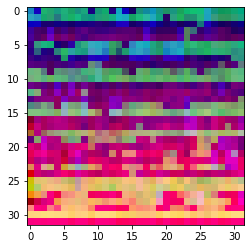

In [ ]:
plt.imshow(train_com[0].astype('float32')/255)

### 1.6 Predition

In [8]:
def pred_label(model, X_test):
  y_prob = model.predict(X_test, verbose = 0)
  y_pred = []
  for i in y_prob:
    label = np.argmax(i)
    y_pred.append(label)

  return y_pred

In [9]:
def plot_cm(y_true, y_pred):
  label_name = ["aircon", "horn", "child", "dog", "drill", "engine", "gun", "hammer", "siren", "music"]
  y_t = []
  for i in y_true:
    y_t.append(label_name[i])
  y_p = []
  for j in y_pred:
    y_p.appedn(label_name[j])
  cm = confusion_matrix(y_t, y_p, labels=label_name)
  plt.figure(figsize = (16,8))
  df_cm = pd.DataFrame(cm, label_name, label_name)
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, cmap="YlGnBu")

# 2 Convolution Neural Network

## 2.1 Image Classification

### 2.1.1 Image of Mel-Frequency Spectrogram

In [10]:
mel_train_array = np.load('/content/drive/MyDrive/machine learning/mel_train_array.npy')
mel_valid_array = np.load('/content/drive/MyDrive/machine learning/mel_valid_array.npy')
mel_test_array = np.load('/content/drive/MyDrive/machine learning/mel_test_array.npy')

In [11]:
X_train = mel_train_array.astype('float32')/255 
X_valid = mel_valid_array.astype('float32')/255
X_test = mel_test_array.astype('float32')/255

In [12]:
y_train = np_utils.to_categorical(train_meta_split['label'], 10)
y_valid = np_utils.to_categorical(valid_meta_split['label'], 10)
y_test = np_utils.to_categorical(test_meta_split['label'], 10)

In [13]:
X_train, y_train = shuffle(X_train, y_train) 
X_valid, y_valid = shuffle(X_valid, y_valid)

In [14]:
X_train.shape

(27809, 32, 32, 3)

#### 2.1.1.1 VGG with 1 bolck

In [27]:
model_cnn_mel_img_1 = Sequential([
     Conv2D(32, kernel_size = (3, 3), strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)),
     Conv2D(32, kernel_size = (3, 3), strides=1, padding='same',activation='relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),   

     Flatten(),

     Dense(128, activation='relu'),
     Dropout(0.2),

     Dense(10, activation='softmax')
])

model_cnn_mel_img_1.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])


model_cnn_mel_img_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [28]:
es_cnn_mel_img_1 = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

In [ ]:
history_cnn_mel_img_1 = model_cnn_mel_img_1.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_data = (X_valid, y_valid), verbose = 1, callbacks = [es_cnn_mel_img_1])

Epoch 1/50
1739/1739 [==============================] - 101s 58ms/step - loss: 1.0480 - accuracy: 0.6351 - val_loss: 2.1753 - val_accuracy: 0.4753
Epoch 2/50
 586/1739 [=========>....................] - ETA: 1:03 - loss: 0.6146 - accuracy: 0.7907

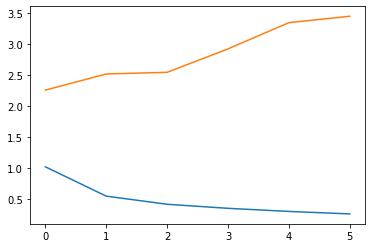

In [18]:
plt.plot(history_cnn_mel_img_1.history['loss'], label='Train')
plt.plot(history_cnn_mel_img_1.history['val_loss'], label='Valid')
plt.show()

In [19]:
model1 = pd.DataFrame(history_cnn_mel_img_1.history.history)

In [20]:
model1

,loss,accuracy,val_loss,val_accuracy
0,1.015204,0.650725,2.256615,0.409562
1,0.541108,0.813082,2.517677,0.411847
2,0.410069,0.855371,2.544518,0.473545
3,0.344342,0.877809,2.923407,0.455089
4,0.294073,0.894135,3.347703,0.459835
5,0.253964,0.909490,3.451260,0.457022


In [22]:
y_pred = pred_label(model_cnn_mel_img_1, X_test)

In [23]:
zero_one_loss(test_meta_split['label'], y_pred)

0.5255655558258332

In [24]:
accuracy_score(test_meta_split['label'], y_pred)

0.47443444417416686

In [26]:
test_meta_split[test_meta_split['fold']=='fold7']

,Unnamed: 0,name,fold,label
0,0,201988-5-0-5,fold7,5
1,1,201988-5-0-5,fold7,5
2,2,201988-5-0-5,fold7,5
3,3,201988-5-0-5,fold7,5
4,4,201988-5-0-5,fold7,5
...,...,...,...,...
5272,5272,74850-9-0-11,fold7,9
5273,5273,74850-9-0-11,fold7,9
5274,5274,74850-9-0-11,fold7,9
5275,5275,74850-9-0-11,fold7,9


#### 2.1.1.2 VGG with 3 blocks

In [ ]:
model_cnn_mel_img_3 = Sequential([
     Conv2D(32, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu', input_shape = (32, 32, 3)),
     Conv2D(32, kernel_size = (3, 3), strides = 1, padding= 'same', activation='relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),  

     Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'),
     Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),  

     Conv2D(128, kernel_size=(3, 3), strides = 1, padding = 'same', activation='relu'),
     Conv2D(128, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2), 

     Flatten(),

     Dense(128, activation = 'relu'),
     Dropout(0.2),

     Dense(10, activation = 'softmax')
])
     
model_cnn_mel_img_3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model_cnn_mel_img_3.summary()

In [ ]:
history_cnn_mel_img_3 = model_cnn_mel_img_3.fit(X_train, y_train, batch_size=16, epochs=15, validation_data=(X_valid, y_valid)) 

### 2.1.2 Combined image

In [ ]:
train_com = img_combine(mel_train_array, mfcc_train_array, chroma_train_array)
test_com = img_combine(mel_test_array, mfcc_test_array, chroma_test_array)
valid_com = img_combine(mel_valid_array, mfcc_valid_array, chroma_valid_array)

In [ ]:
X_train = train_com.astype('float32')/255
X_test = test_com.astype('float32')/255
X_valid = valid_com.astype('float32')/255

In [ ]:
y_train = np_utils.to_categorical(train_meta_split['label'], 10)
y_valid = np_utils.to_categorical(valid_meta_split['label'], 10)
y_test = np_utils.to_categorical(test_meta_split['label'], 10)

In [ ]:
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
model_cnn_com_1 = Sequential([
     Conv2D(32, kernel_size = (3, 3), strides=1, padding = 'same', activation = 'relu', input_shape = (32, 32, 3)),
     Conv2D(32, kernel_size = (3, 3), strides=1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),   

     Flatten(),

     Dense(128, activation = 'relu'),
     Dropout(0.2),

     Dense(10, activation = 'softmax')
])
model_cnn_com_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


model_cnn_com_1.summary()

In [ ]:
history_cnn_com_1 = model_cnn_com_1.fit(X_train, y_train, batch_size = 16, epochs=10, validation_data = (X_valid, y_valid))

In [ ]:
model_cnn_com_3 = Sequential([
     Conv2D(32, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu', input_shape = (32, 32, 3)),
     Conv2D(32, kernel_size = (3, 3), strides = 1, padding= 'same', activation='relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),  

     Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'),
     Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),  

     Conv2D(128, kernel_size=(3, 3), strides = 1, padding = 'same', activation='relu'),
     Conv2D(128, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2), 

     Flatten(),

     Dense(128, activation = 'relu'),
     Dropout(0.2),

     Dense(10, activation = 'softmax')
])
     
model_cnn_com_3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model_cnn_com_3.summary()

In [ ]:
history_cnn_com_3 = model_cnn_com_3.fit(X_train, y_train, batch_size = 16, epochs = 15, validation_data = (X_valid, y_valid)) 

## 2.2 Classification with Features

- Mel-frequency Spectrogram: 128
- Chromagram: 12
- Tonnetz: 6
- MFCCs: 50

In [ ]:
all_feature_train = np.load('/content/drive/MyDrive/machine learning/all_feature_train.npy')
all_feature_valid = np.load('/content/drive/MyDrive/machine learning/all_feature_valid.npy')
all_feature_test = np.load('/content/drive/MyDrive/machine learning/all_feature_test.npy')

In [ ]:
def add_delta(data):
  two_channel = data[:,:,:,np.newaxis]
  two_channel = np.concatenate((two_channel, np.zeros(np.shape(two_channel))), axis =3)
  for i in range(len(data)):
    feature = two_channel[i,:,:,0].T
    two_channel[i,:,:,1] = librosa.feature.delta(feature).T
  return two_channel

### 2.2.1 Spectrogram features

In [ ]:
mel_train_data = all_feature_train[:,:,:128]
mel_valid_data = all_feature_valid[:,:,:128]
mel_test_data = all_feature_test[:,:,:128]

In [ ]:
X_train = add_delta(mel_train_data)
X_valid = add_delta(mel_valid_data)
X_test = add_delta(mel_test_data)

In [ ]:
y_train_label = train_meta_split['label']
y_valid_label = valid_meta_split['label']
y_test_label = test_meta_split['label']

In [ ]:
y_train = np_utils.to_categorical(y_train_label, 10)
y_valid = np_utils.to_categorical(y_valid_label, 10)
y_test = np_utils.to_categorical(y_test_label, 10)

In [ ]:
X_train,y_train = shuffle(X_train, y_train) 
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
X_train.shape

(27809, 41, 128, 2)

In [ ]:
model_cnn_mel_1 = Sequential([
     Conv2D(32, kernel_size = (3, 3), strides=1, padding = 'same', activation = 'relu', input_shape = (41, 128, 2)),
     Conv2D(32, kernel_size = (3, 3), strides=1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),   

     Flatten(),

     Dense(128, activation = 'relu'),
     Dropout(0.2),

     Dense(10, activation = 'softmax')
])
model_cnn_mel_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


model_cnn_mel_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 41, 128, 32)       608       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 128, 32)       1056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 64, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5243008   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [ ]:
history_cnn_mel_1 = model_cnn_mel_1.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_valid, y_valid)) 

Epoch 1/15
1739/1739 [==============================] - 51s 13ms/step - loss: 2.3620 - accuracy: 0.3170 - val_loss: 1.8634 - val_accuracy: 0.3201
Epoch 2/15
1739/1739 [==============================] - 21s 12ms/step - loss: 1.3193 - accuracy: 0.5433 - val_loss: 1.6654 - val_accuracy: 0.4416
Epoch 3/15
1739/1739 [==============================] - 20s 12ms/step - loss: 0.9666 - accuracy: 0.6583 - val_loss: 1.6688 - val_accuracy: 0.5029
Epoch 4/15
1739/1739 [==============================] - 21s 12ms/step - loss: 0.7592 - accuracy: 0.7280 - val_loss: 2.4521 - val_accuracy: 0.4939
Epoch 5/15
1739/1739 [==============================] - 20s 12ms/step - loss: 0.6147 - accuracy: 0.7805 - val_loss: 2.4526 - val_accuracy: 0.5500
Epoch 6/15
1739/1739 [==============================] - 20s 11ms/step - loss: 0.5023 - accuracy: 0.8177 - val_loss: 2.2013 - val_accuracy: 0.5929
Epoch 7/15
1739/1739 [==============================] - 22s 13ms/step - loss: 0.4393 - accuracy: 0.8424 - val_loss: 2.9193 -

In [ ]:
model_cnn_mel_3 = Sequential([
     Conv2D(32, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu', input_shape = (41, 128, 2)),
     Conv2D(32, kernel_size = (3, 3), strides = 1, padding= 'same', activation='relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),  

     Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'),
     Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),  

     Conv2D(128, kernel_size=(3, 3), strides = 1, padding = 'same', activation='relu'),
     Conv2D(128, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2), 

     Flatten(),

     Dense(128, activation = 'relu'),
     Dropout(0.2),

     Dense(10, activation = 'softmax')
])
     
model_cnn_mel_3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model_cnn_mel_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 41, 128, 32)       608       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 128, 32)       1056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 64, 64)        4160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 32, 64)        0

In [ ]:
history_cnn_mel_3 = model_cnn_mel_3.fit(X_train, y_train, batch_size = 16, epochs = 15, validation_data = (X_valid, y_valid)) 

Epoch 1/15
1739/1739 [==============================] - 63s 19ms/step - loss: 1.2335 - accuracy: 0.5691 - val_loss: 1.8707 - val_accuracy: 0.5454
Epoch 2/15
1739/1739 [==============================] - 34s 19ms/step - loss: 0.5539 - accuracy: 0.8117 - val_loss: 2.2257 - val_accuracy: 0.5085
Epoch 3/15
1739/1739 [==============================] - 31s 18ms/step - loss: 0.4022 - accuracy: 0.8612 - val_loss: 2.4523 - val_accuracy: 0.5737
Epoch 4/15
1739/1739 [==============================] - 33s 19ms/step - loss: 0.3280 - accuracy: 0.8864 - val_loss: 2.5677 - val_accuracy: 0.5514
Epoch 5/15
1739/1739 [==============================] - 33s 19ms/step - loss: 0.2817 - accuracy: 0.9022 - val_loss: 2.2389 - val_accuracy: 0.5743
Epoch 6/15
1739/1739 [==============================] - 31s 18ms/step - loss: 0.2431 - accuracy: 0.9165 - val_loss: 2.3260 - val_accuracy: 0.5982
Epoch 7/15
1739/1739 [==============================] - 34s 19ms/step - loss: 0.2143 - accuracy: 0.9253 - val_loss: 3.3990 -

### 2.2.2 All features

In [ ]:
X_train = add_delta(all_feature_train)
X_valid = add_delta(all_feature_valid)
X_test = add_delta(all_feature_test)

In [ ]:
y_train_label = train_meta_split['label']
y_valid_label = valid_meta_split['label']
y_test_label = test_meta_split['label']

In [ ]:
y_train = np_utils.to_categorical(y_train_label, 10)
y_valid = np_utils.to_categorical(y_valid_label, 10)
y_test = np_utils.to_categorical(y_test_label, 10)

In [ ]:
X_train,y_train = shuffle(X_train, y_train) 
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
model_cnn_all_1 = Sequential([
     Conv2D(32, kernel_size = (3, 3), strides=1, padding = 'same', activation = 'relu', input_shape = (41, 190, 2)),
     Conv2D(32, kernel_size = (3, 3), strides=1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),   

     Flatten(),

     Dense(128, activation = 'relu'),
     Dropout(0.2),

     Dense(10, activation = 'softmax')
])
model_cnn_all_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


model_cnn_all_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 41, 128, 32)       608       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 128, 32)       1056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 64, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5243008   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [ ]:
history_cnn_all_1 = model_cnn_all_1.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_valid, y_valid)) 

Epoch 1/15
1739/1739 [==============================] - 51s 13ms/step - loss: 2.3620 - accuracy: 0.3170 - val_loss: 1.8634 - val_accuracy: 0.3201
Epoch 2/15
1739/1739 [==============================] - 21s 12ms/step - loss: 1.3193 - accuracy: 0.5433 - val_loss: 1.6654 - val_accuracy: 0.4416
Epoch 3/15
1739/1739 [==============================] - 20s 12ms/step - loss: 0.9666 - accuracy: 0.6583 - val_loss: 1.6688 - val_accuracy: 0.5029
Epoch 4/15
1739/1739 [==============================] - 21s 12ms/step - loss: 0.7592 - accuracy: 0.7280 - val_loss: 2.4521 - val_accuracy: 0.4939
Epoch 5/15
1739/1739 [==============================] - 20s 12ms/step - loss: 0.6147 - accuracy: 0.7805 - val_loss: 2.4526 - val_accuracy: 0.5500
Epoch 6/15
1739/1739 [==============================] - 20s 11ms/step - loss: 0.5023 - accuracy: 0.8177 - val_loss: 2.2013 - val_accuracy: 0.5929
Epoch 7/15
1739/1739 [==============================] - 22s 13ms/step - loss: 0.4393 - accuracy: 0.8424 - val_loss: 2.9193 -

In [ ]:
model_cnn_all_3 = Sequential([
     Conv2D(32, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu', input_shape = (41, 190, 2)),
     Conv2D(32, kernel_size = (3, 3), strides = 1, padding= 'same', activation='relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),  

     Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'),
     Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),  

     Conv2D(128, kernel_size=(3, 3), strides = 1, padding = 'same', activation='relu'),
     Conv2D(128, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2), 

     Flatten(),

     Dense(128, activation = 'relu'),
     Dropout(0.2),

     Dense(10, activation = 'softmax')
])
     
model_cnn_all_3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model_cnn_all_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 41, 128, 32)       608       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 128, 32)       1056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 64, 64)        4160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 32, 64)        0

In [ ]:
history_cnn_all_3 = model_cnn_all_3.fit(X_train, y_train, batch_size = 16, epochs = 15, validation_data = (X_valid, y_valid)) 

Epoch 1/15
1739/1739 [==============================] - 63s 19ms/step - loss: 1.2335 - accuracy: 0.5691 - val_loss: 1.8707 - val_accuracy: 0.5454
Epoch 2/15
1739/1739 [==============================] - 34s 19ms/step - loss: 0.5539 - accuracy: 0.8117 - val_loss: 2.2257 - val_accuracy: 0.5085
Epoch 3/15
1739/1739 [==============================] - 31s 18ms/step - loss: 0.4022 - accuracy: 0.8612 - val_loss: 2.4523 - val_accuracy: 0.5737
Epoch 4/15
1739/1739 [==============================] - 33s 19ms/step - loss: 0.3280 - accuracy: 0.8864 - val_loss: 2.5677 - val_accuracy: 0.5514
Epoch 5/15
1739/1739 [==============================] - 33s 19ms/step - loss: 0.2817 - accuracy: 0.9022 - val_loss: 2.2389 - val_accuracy: 0.5743
Epoch 6/15
1739/1739 [==============================] - 31s 18ms/step - loss: 0.2431 - accuracy: 0.9165 - val_loss: 2.3260 - val_accuracy: 0.5982
Epoch 7/15
1739/1739 [==============================] - 34s 19ms/step - loss: 0.2143 - accuracy: 0.9253 - val_loss: 3.3990 -

# 3 Convolution Recurrent Neural Network

## 3.1 CRNN with Mel-Frequency Spectrogram

In [ ]:
mel_valid_data = mel_data(valid_raw_split)

In [ ]:
mel_train_data = mel_data(train_raw_split)

In [ ]:
train_label = train_meta_split['label']
valid_label = valid_meta_split['label']

In [ ]:
y_train = np_utils.to_categorical(train_label,10)
y_valid = np_utils.to_categorical(valid_label,10)

In [ ]:
X_train = mel_train_data
X_valid = mel_valid_data

In [ ]:
X_train,y_train = shuffle(X_train,y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
model_crnn = Sequential([
    Conv1D(16, 1, activation='relu', input_shape = (41,128)),
    MaxPooling1D(2),
    Dropout(0.1),

    Conv1D(32, 1, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.1),

    Conv1D(64, 1, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.1),    
  

    LSTM(96, return_sequences=False),
    Dropout(0.4),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation = 'softmax')
])


optimizer = adam_v2.Adam(learning_rate=0.001)
model_crnn.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


model_crnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 41, 16)            2064      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 20, 16)            0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 20, 16)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 20, 32)            544       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 10, 32)            0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 10, 32)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 10, 64)           

In [ ]:
history = model_crnn.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_valid, y_valid))

## 3.2 With all features

In [ ]:
X_train = all_feature_train
X_valid = all_feature_valid

In [ ]:
y_train = np_utils.to_categorical(train_meta_split['label'],10)
y_valid = np_utils.to_categorical(valid_meta_split['label'],10)

In [ ]:
X_train,y_train = shuffle(X_train,y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
model_crnn_all = Sequential([
    Conv1D(16, 1, activation='relu', input_shape = (41,190)),
    MaxPooling1D(2),
    Dropout(0.1),

    Conv1D(32, 1, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.1),

    Conv1D(64, 1, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.1),    
  

    LSTM(96, return_sequences=False),
    Dropout(0.4),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation = 'softmax')
])


optimizer = adam_v2.Adam(learning_rate=0.001)
model_crnn_all.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


model_crnn_all.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 41, 16)            3056      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 20, 16)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 16)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 20, 32)            544       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 10, 64)           

In [ ]:
history = model_crnn_all.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_valid, y_valid)) 

# 4 Parallel CNN-RNN Model

## 4.1 with Mel-Frequency Spectrogram

In [ ]:
def parallel_cnn_rnn(model_input):
  print('Builing model...')
  layer = model_input

  ## CNN block
  conv_1 = Conv2D(16, (3, 1), strides=1, padding = 'same', activation='relu')(layer)
  pool_1 = MaxPooling2D((2,2))(conv_1)

  conv_2 = Conv2D(32, (3, 1), strides=1, padding = 'same', activation='relu')(pool_1)
  pool_2 = MaxPooling2D((2,2))(conv_2)

  conv_3 = Conv2D(64, (3, 1), strides=1, padding = 'same', activation='relu')(pool_2)
  pool_3 = MaxPooling2D((2,2))(conv_3)

  conv_4 = Conv2D(64, (3, 1), strides=1, padding = 'same', activation='relu')(pool_3)
  pool_4 = MaxPooling2D((2,2))(conv_4)

  conv_5 = Conv2D(64, (3, 1), strides=1, padding = 'same', activation='relu')(pool_4)
  pool_5 = MaxPooling2D((2,2))(conv_5)

  flatten_1 = Flatten()(pool_5)

  ## Bi-RNN block
  pool_lstm1 = MaxPooling2D((4,2))(layer)
  squeezed = Lambda(lambda x: keras.backend.squeeze(x, axis= -1))(pool_lstm1)
  lstm = Bidirectional(GRU(64))(squeezed)

  ## Concat two output
  concat = concatenate([flatten_1, lstm], axis=-1)
  output = Dense(10, activation = 'softmax')(concat)

  model_output = output

  model = Model(model_input, model_output)

  optimizer = adam_v2.Adam(learning_rate=0.001)
  model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  print(model.summary())
  
  return model

In [ ]:
model_input = Input((41,128,1))
model_pcrnn = parallel_cnn_rnn(model_input)

Builing model...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 41, 128, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 41, 128, 16)  64          input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_48 (MaxPooling2D) (None, 20, 64, 16)   0           conv2d_52[0][0]                  
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 20, 64, 32)   1568        max_pooling2d_48[0][0]           
___________________________________________________________________________

In [ ]:
X_train = mel_train_data
X_valid = mel_valid_data

In [ ]:
y_train = np_utils.to_categorical(train_meta_split['label'], 10)
y_valid = np_utils.to_categorical(valid_meta_split['label'], 10)

In [ ]:
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
X_train.shape

(27809, 41, 128)

In [ ]:
X_train_new = X_train[:,:,:, np.newaxis]
X_valid_new = X_valid[:,:,:, np.newaxis]

In [ ]:
history = model_pcrnn.fit(X_train_new, y_train, batch_size=16, epochs=20, validation_data=(X_valid_new, y_valid))

Epoch 1/20
1739/1739 [==============================] - 15s 8ms/step - loss: 1.4123 - accuracy: 0.5054 - val_loss: 1.5817 - val_accuracy: 0.4746
Epoch 2/20
1739/1739 [==============================] - 13s 8ms/step - loss: 1.0647 - accuracy: 0.6281 - val_loss: 1.4374 - val_accuracy: 0.5219
Epoch 3/20
1739/1739 [==============================] - 13s 8ms/step - loss: 0.9034 - accuracy: 0.6896 - val_loss: 1.4349 - val_accuracy: 0.5410
Epoch 4/20
1739/1739 [==============================] - 13s 8ms/step - loss: 0.7966 - accuracy: 0.7339 - val_loss: 1.4858 - val_accuracy: 0.5481
Epoch 5/20
1739/1739 [==============================] - 13s 8ms/step - loss: 0.7023 - accuracy: 0.7643 - val_loss: 1.4322 - val_accuracy: 0.5409
Epoch 6/20
1739/1739 [==============================] - 13s 8ms/step - loss: 0.6511 - accuracy: 0.7828 - val_loss: 1.3742 - val_accuracy: 0.5968
Epoch 7/20
1739/1739 [==============================] - 13s 8ms/step - loss: 0.5923 - accuracy: 0.8033 - val_loss: 1.4562 - val_ac